In [44]:
import secrets, base64, qrcode, time, struct, hmac, hashlib


## Step 1: Generate a Secret Key

In [70]:
# Step 1 function: generate secret and base32 version
def generate_secret(length: int = 20):
    secret_bytes = secrets.token_bytes(length)
    base32 = base64.b32encode(secret_bytes).decode("utf-8").replace("=", "")
    return secret_bytes, base32



## Step 2: Generate the QR Code URL for Client Onboarding

In [77]:
# Step 2 function: build provisioning URI and return it
def build_provisioning_uri(issuer: str, account: str, secret_b32: str, digits: int = 6, period: int = 30, algorithm: str = "SHA1"):
    return (
        f"otpauth://totp/{issuer}:{account}?secret={secret_b32}"
        f"&issuer={issuer}&algorithm={algorithm}&digits={digits}&period={period}"
    )


# Step 3: Generating a counter and Packing the counter into an 8-byte big-endian array

In [79]:
# Step 3 function: compute counter and packed bytes
def compute_counter(t0: int = 0, period: int = 30, now: int | None = None):
    if now is None:
        now = int(time.time())
    counter_val = int((now - t0) / period)
    return counter_val, struct.pack(">Q", counter_val)


# Step 4 : Compute the HMAC digest

In [ ]:
# Step 4 (part 1) function: derive key from Base32 secret
def derive_key(base32_secret: str):
    return base64.b32decode(base32_secret.upper().replace(' ', ''), casefold=True)

key = derive_key(base32_secret)

In [52]:
# Step 4 (part 2) function: compute HMAC digest
def compute_mac(key: bytes, counter: int):
    counter_bytes_local = struct.pack(">Q", counter)
    return hmac.new(key, counter_bytes_local, hashlib.sha1).digest()

mac = compute_mac(key, counter)
mac

b'\x9a\xa6\x0b\xd9U\xb1\x10g?M\xa4\xcd\x91\xdd\xf8\x92\xeca\xb1\x8b'

# Step 5: Generate the OTP

In [ ]:
# Step 5 (part 1) function: dynamic truncation
def dynamic_truncate(mac: bytes):
    offset_local = mac[-1] & 0x0F
    dbc_local = mac[offset_local:offset_local+4]
    code_int_local = int.from_bytes(dbc_local, 'big') & 0x7FFFFFFF
    return offset_local, dbc_local, code_int_local

offset, dbc, code_int = dynamic_truncate(mac)

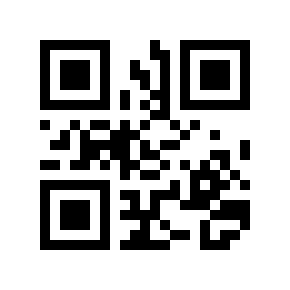

In [69]:
# Step 5 (part 2) function: generate OTP and optionally QR
def generate_otp(code_int: int, digits: int = 6):
    return str(code_int % (10 ** digits)).zfill(digits)

def otp_qr(otp: str):
    return qrcode.make(otp)

digits = 6
otp = generate_otp(code_int, digits)
otp_qr(otp)

In [75]:
secret, base32_secret = generate_secret()


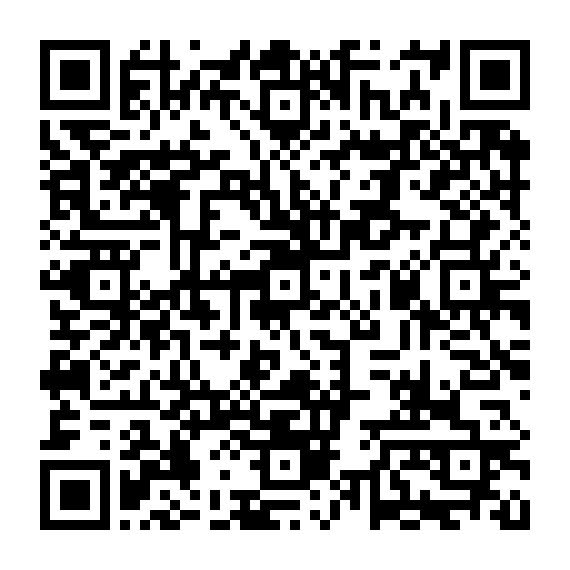

In [78]:
issuer = "Aneesh Patne"
account = "aneesh@example.com"
URI = build_provisioning_uri(issuer, account, base32_secret)
qrcode.make(URI)

In [ ]:
now = int(time.time())
t0, period = 0, 30
counter, counter_bytes = compute_counter(t0=t0, period=period, now=now)
counter_bytes

b'\x00\x00\x00\x00\x03}\xf2\xe8'